## 1. Installs and Imports
This notebook implements a Decision Transformer for the `LunarLander-v3` environment, using a pre-generated offline dataset and a CNN to encode the initial visual state.

In [2]:
import os
import random
import csv
from datetime import datetime
import collections
import math
import pickle

import numpy as np
import gymnasium as gym
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## 2. Configuration Parameters
Parameters for the environment, training, and model architecture. **You must set the `dataset_path` variable to point to your dataset file.**

In [3]:
# --- Environment and Dataset Parameters ---
env_name = 'LunarLander-v3'
# 🔴 SET THIS HYPERPARAMETER to the path of your generated dataset file
dataset_path = 'TRAJECTORIES_FLATLANDER_WITH_SEED_RUGGED/Trajectories_rugged_min_0_max_150_step_5_unique_1000.pkl'

rtg_target = 100                
rtg_scale = 100                 # Scale to normalize returns to go

# --- Evaluation Parameters ---
max_eval_ep_len = 1000      # Max length of one evaluation episode
num_eval_ep = 10            # Number of evaluation episodes per iteration

# --- Training Parameters ---
batch_size = 64             # Training batch size
lr = 1e-4                   # Learning rate
wt_decay = 1e-4             # Weight decay
warmup_steps = 5000         # Warmup steps for lr scheduler
max_train_iters = 200       # Try 500 
num_updates_per_iter = 100  # Try 1000

# --- Model Parameters ---
context_len = 20        # K in decision transformer (can try changing to 50)
n_blocks = 3            # Num of transformer blocks
embed_dim = 256         # Embedding (hidden) dim of transformer (try changing to 256)
n_heads = 1             # Num of transformer heads (8 = previous)
dropout_p = 0.1         # Dropout probability
vision_dim = 256          # Dimension of the CNN output vector

# --- Logging and Device ---
log_dir = "./dt_runs_lunarlander_vision/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Vision and Transformer Models

In [11]:
class CNNTo128DVector(nn.Module):
    def __init__(self):
        super(CNNTo128DVector, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # (3, 200, 600) -> (16, 100, 300)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # (32, 50, 150)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (64, 25, 75)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))                          # (64, 4, 4)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),                                         # (64*4*4 = 1024)
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 128)                                     # Final 256-D output
        )
        
    def forward(self, x):
        # PyTorch expects input as (B, C, H, W)
        x = x.permute(0, 3, 1, 2) 
        x = self.cnn(x)
        x = self.fc(x)
        return x

class MaskedCausalAttention(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()
        self.n_heads = n_heads
        self.max_T = max_T
        self.q_net = nn.Linear(h_dim, h_dim)
        self.k_net = nn.Linear(h_dim, h_dim)
        self.v_net = nn.Linear(h_dim, h_dim)
        self.proj_net = nn.Linear(h_dim, h_dim)
        self.att_drop = nn.Dropout(drop_p)
        self.proj_drop = nn.Dropout(drop_p)
        ones = torch.ones((max_T, max_T))
        mask = torch.tril(ones).view(1, 1, max_T, max_T)
        self.register_buffer('mask',mask)

    def forward(self, x):
        B, T, C = x.shape
        N, D = self.n_heads, C // self.n_heads
        q = self.q_net(x).view(B, T, N, D).transpose(1,2)
        k = self.k_net(x).view(B, T, N, D).transpose(1,2)
        v = self.v_net(x).view(B, T, N, D).transpose(1,2)
        weights = q @ k.transpose(2,3) / math.sqrt(D)
        weights = weights.masked_fill(self.mask[...,:T,:T] == 0, float('-inf'))
        normalized_weights = F.softmax(weights, dim=-1)
        attention = self.att_drop(normalized_weights @ v)
        attention = attention.transpose(1, 2).contiguous().view(B,T,N*D)
        out = self.proj_drop(self.proj_net(attention))
        return out

class Block(nn.Module):
    def __init__(self, h_dim, max_T, n_heads, drop_p):
        super().__init__()
        self.attention = MaskedCausalAttention(h_dim, max_T, n_heads, drop_p)
        self.mlp = nn.Sequential(
                nn.Linear(h_dim, 4*h_dim),
                nn.GELU(),
                nn.Linear(4*h_dim, h_dim),
                nn.Dropout(drop_p),
            )
        self.ln1 = nn.LayerNorm(h_dim)
        self.ln2 = nn.LayerNorm(h_dim)

    def forward(self, x):
        x = x + self.attention(x)
        x = self.ln1(x)
        x = x + self.mlp(x)
        x = self.ln2(x)
        return x

class DecisionTransformer(nn.Module):
    def __init__(self, state_dim, act_dim, vision_dim, n_blocks, h_dim, context_len,
                 n_heads, drop_p, max_timestep=4096):
        super().__init__()
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.vision_dim = vision_dim
        self.h_dim = h_dim
        self.context_len = context_len

        # The new input sequence length for the attention mechanism is 1 (vision) + 3*(K-1) (r,s,a)
        input_seq_len = 1 + 3 * (context_len - 1)
        blocks = [Block(h_dim, input_seq_len, n_heads, drop_p) for _ in range(n_blocks)]
        self.transformer = nn.Sequential(*blocks)

        self.embed_ln = nn.LayerNorm(h_dim)
        self.embed_timestep = nn.Embedding(max_timestep, h_dim)
        self.embed_rtg = torch.nn.Linear(1, h_dim)
        self.embed_state = torch.nn.Linear(state_dim, h_dim)
        self.embed_action = torch.nn.Embedding(act_dim, h_dim)# New embedding layer for the 8-D vision vector
        self.embed_vision = torch.nn.Linear(vision_dim, h_dim)
        # Positional embedding for the vision token (at position 0)
        self.pos_emb_vision = nn.Parameter(torch.zeros(1, 1, h_dim))

        self.predict_rtg = torch.nn.Linear(h_dim, 1)
        self.predict_state = torch.nn.Linear(h_dim, state_dim)
        self.predict_action = nn.Linear(h_dim, act_dim)

    def forward(self, vision_vectors, timesteps, states, actions, returns_to_go):
        B, T, _ = states.shape # Here T is context_len - 1
        
        # Embed the 8-D vision vector and add its unique positional embedding
        vision_embedding = self.embed_vision(vision_vectors).unsqueeze(1) + self.pos_emb_vision

        # Embed trajectory sequence (r, s, a) for T steps
        time_embeddings = self.embed_timestep(timesteps)
        state_embeddings = self.embed_state(states) + time_embeddings
        action_embeddings = self.embed_action(actions) + time_embeddings
        returns_embeddings = self.embed_rtg(returns_to_go) + time_embeddings

        # Reshape trajectory embeddings so we can interleave them
        h_traj = torch.stack(
            (returns_embeddings, state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(B, 3 * T, self.h_dim)

        # Concatenate the vision token at the start of the sequence
        h = torch.cat((vision_embedding, h_traj), dim=1)
        h = self.embed_ln(h)

        # Transformer forward pass
        h = self.transformer(h)

        # Predictions
        # The indices are shifted by 1 because of the vision token
        # h[:, 0] is vision, h[:, 1] is r_0, h[:, 2] is s_0, etc.
        # Predict action given vision, r_t, s_t
        action_preds = self.predict_action(h[:, 2::3])
        # Predict state given vision, r_t, s_t, a_t
        state_preds = self.predict_state(h[:, 3::3])
        # Predict rtg given vision, r_t, s_t, a_t
        return_preds = self.predict_rtg(h[:, 3::3])

        return state_preds, action_preds, return_preds

## 4. Utilities and Dataset Class

In [12]:
def discount_cumsum(x, gamma):
    disc_cumsum = np.zeros_like(x)
    disc_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        disc_cumsum[t] = x[t] + gamma * disc_cumsum[t+1]
    return disc_cumsum

def compute_dataset_stats(trajectories):
    all_states = np.concatenate([traj['states'] for traj in trajectories], axis=0)
    state_mean = np.mean(all_states, axis=0)
    state_std = np.std(all_states, axis=0) + 1e-6
    return state_mean, state_std

class TrajectoryDataset(Dataset):
    def __init__(self, trajectories, context_len, rtg_scale, state_mean, state_std):
        self.context_len = context_len
        self.state_mean = torch.from_numpy(state_mean).float()
        self.state_std = torch.from_numpy(state_std).float()
        self.trajectories = []

        for traj in trajectories:
            obs_norm = (torch.from_numpy(traj['states']).float() - self.state_mean) / self.state_std
            rtg = discount_cumsum(traj['rewards'], 1.0) / rtg_scale
            
            self.trajectories.append({
                'observations': obs_norm,
                'actions': torch.from_numpy(traj['actions']).long(),
                'returns_to_go': torch.from_numpy(rtg).float(),
                'vision_vector': torch.from_numpy(traj['vision_vector']).float()
            })

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        traj = self.trajectories[idx]
        traj_len = traj['observations'].shape[0]
        
        # The vision vector is the same for the whole trajectory
        vision_vector = traj['vision_vector']

        # We sample a sequence of K-1 triplets
        si = random.randint(0, traj_len - 1)
        
        # Note: The context for (r,s,a) is now context_len - 1
        k_minus_1 = self.context_len - 1
        
        states = traj['observations'][si : si + k_minus_1]
        actions = traj['actions'][si : si + k_minus_1]
        returns_to_go = traj['returns_to_go'][si : si + k_minus_1].unsqueeze(-1)
        timesteps = torch.arange(si, si + states.shape[0])

        # Padding
        tlen = states.shape[0]
        states = torch.cat([states, torch.zeros((k_minus_1 - tlen, states.shape[1]))], 0)
        actions = torch.cat([actions, torch.zeros(k_minus_1 - tlen, dtype=torch.long)], 0)
        returns_to_go = torch.cat([returns_to_go, torch.zeros((k_minus_1 - tlen, 1))], 0)
        timesteps = torch.cat([timesteps, torch.zeros(k_minus_1 - tlen, dtype=torch.long)], 0)
        traj_mask = torch.cat([torch.ones(tlen, dtype=torch.long), torch.zeros(k_minus_1 - tlen, dtype=torch.long)], 0)

        return vision_vector, timesteps, states, actions, returns_to_go, traj_mask

# class TrajectoryDataset(Dataset):
#     def __init__(self, trajectories, context_len, rtg_scale, state_mean, state_std):
#         self.context_len = context_len
#         self.state_mean = torch.from_numpy(state_mean).float()
#         self.state_std = torch.from_numpy(state_std).float()
#         self.trajectories = []

#         for traj in trajectories:
#             obs_norm = (torch.from_numpy(traj['states']).float() - self.state_mean) / self.state_std
#             rtg = discount_cumsum(traj['rewards'], 1.0) / rtg_scale

#             self.trajectories.append({
#                 'observations': obs_norm,
#                 'actions': torch.from_numpy(traj['actions']).long(),
#                 'returns_to_go': torch.from_numpy(rtg).float(),
#                 'vision_vector': torch.from_numpy(traj['vision_vector']).float()
#             })

#     def __len__(self):
#         return len(self.trajectories)

#     def __getitem__(self, idx):
#         traj = self.trajectories[idx]
#         traj_len = traj['observations'].shape[0]

#         k_minus_1 = self.context_len - 1
#         si = random.randint(0, traj_len - 1)

#         states = traj['observations'][si : si + k_minus_1]
#         actions = traj['actions'][si : si + k_minus_1]
#         returns_to_go = traj['returns_to_go'][si : si + k_minus_1].unsqueeze(-1)
#         timesteps = torch.arange(si, si + states.shape[0])

#         # Padding if trajectory is too short
#         tlen = states.shape[0]
#         states = torch.cat([states, torch.zeros((k_minus_1 - tlen, states.shape[1]))], 0)
#         actions = torch.cat([actions, torch.zeros(k_minus_1 - tlen, dtype=torch.long)], 0)
#         returns_to_go = torch.cat([returns_to_go, torch.zeros((k_minus_1 - tlen, 1))], 0)
#         timesteps = torch.cat([timesteps, torch.zeros(k_minus_1 - tlen, dtype=torch.long)], 0)
#         traj_mask = torch.cat([torch.ones(tlen, dtype=torch.long), torch.zeros(k_minus_1 - tlen, dtype=torch.long)], 0)

#         # 🔁 NEW: Repeat vision_vector for each position in context_len
#         # We now return a (context_len, vision_dim) tensor
#         vision_vector = traj['vision_vector'].unsqueeze(0).repeat(self.context_len, 1)

#         return vision_vector, timesteps, states, actions, returns_to_go, traj_mask

## Dataset statistics

✅ Successfully loaded 31000 trajectories from 'TRAJECTORIES_FLATLANDER_WITH_SEED_RUGGED/Trajectories_rugged_min_0_max_150_step_5_unique_1000.pkl'

          DATASET STATISTICS SUMMARY

--- GENERAL ---
Total Trajectories: 31,000
Total Timesteps:    19,359,044

--- REWARDS (per trajectory) ---
Mean:   77.39
Std:    44.69
Min:    0.00
Max:    155.00


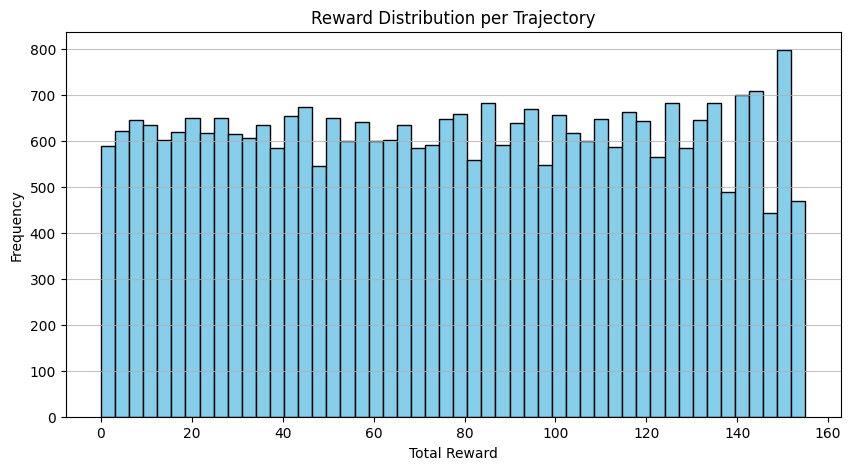


--- TRAJECTORY LENGTHS ---
Mean:   624.49
Std:    431.68
Min:    75
Max:    1000


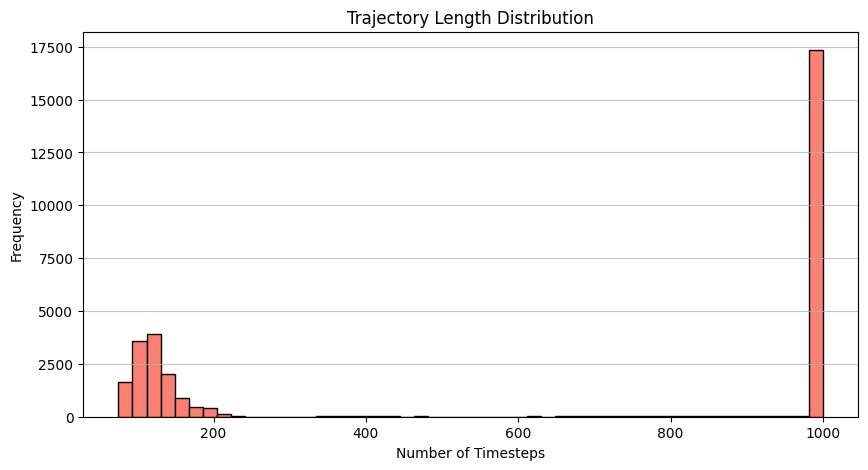


--- ACTIONS ---
Unique Actions Found: [0, 1, 2, 3]
Action Distribution:
  Action 0: 6,078,480 times (31.40%)
  Action 1: 3,702,589 times (19.13%)
  Action 2: 5,871,421 times (30.33%)
  Action 3: 3,706,554 times (19.15%)


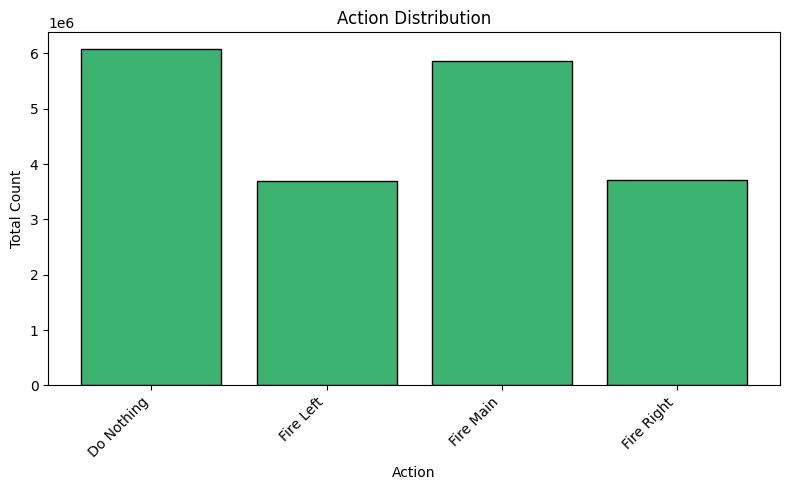


--- STATES ---
State Dimension: 8

Per-dimension stats (mean, std, min, max):
  Dim 00:     0.00,     0.19,    -1.00,     1.00
  Dim 01:     0.13,     0.33,    -0.27,     1.58
  Dim 02:     0.00,     0.23,    -1.23,     1.37
  Dim 03:    -0.10,     0.23,    -1.18,     0.58
  Dim 04:     0.00,     0.13,    -1.03,     1.45
  Dim 05:    -0.00,     0.14,    -2.40,     2.21
  Dim 06:     0.49,     0.50,     0.00,     1.00
  Dim 07:     0.49,     0.50,     0.00,     1.00



In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import collections

class DatasetAnalyzer:
    """
    A class to load and analyze an offline RL dataset of trajectories.

    It calculates and displays key statistics about rewards, trajectory lengths,
    actions, and state dimensions.

    Args:
        dataset_path (str): The full path to the .pkl dataset file.
    """
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.trajectories = self._load_dataset()
        if self.trajectories:
            self.stats = self._calculate_stats()

    def _load_dataset(self):
        """Loads the dataset from the pickle file."""
        try:
            with open(self.dataset_path, 'rb') as f:
                trajectories = pickle.load(f)
            print(f"✅ Successfully loaded {len(trajectories)} trajectories from '{self.dataset_path}'")
            return trajectories
        except FileNotFoundError:
            print(f"❌ Error: Dataset file not found at '{self.dataset_path}'")
            return None
        except Exception as e:
            print(f"An error occurred while loading the dataset: {e}")
            return None

    def _calculate_stats(self):
        """Calculates all the statistics for the loaded dataset."""
        if not self.trajectories:
            return {}

        all_rewards = [np.sum(traj['rewards']) for traj in self.trajectories]
        all_lengths = [len(traj['states']) for traj in self.trajectories]
        all_actions = np.concatenate([traj['actions'] for traj in self.trajectories])
        all_states = np.concatenate([traj['states'] for traj in self.trajectories])

        stats = {
            'total_trajectories': len(self.trajectories),
            'total_timesteps': sum(all_lengths),
            'reward_stats': {
                'mean': np.mean(all_rewards),
                'std': np.std(all_rewards),
                'min': np.min(all_rewards),
                'max': np.max(all_rewards),
                'all': all_rewards
            },
            'length_stats': {
                'mean': np.mean(all_lengths),
                'std': np.std(all_lengths),
                'min': np.min(all_lengths),
                'max': np.max(all_lengths),
                'all': all_lengths
            },
            'action_stats': {
                'distribution': collections.Counter(all_actions),
                'unique_actions': sorted(list(np.unique(all_actions)))
            },
            'state_stats': {
                'dimension': all_states.shape[1],
                'mean': np.mean(all_states, axis=0),
                'std': np.std(all_states, axis=0),
                'min': np.min(all_states, axis=0),
                'max': np.max(all_states, axis=0)
            }
        }
        return stats

    def display_summary(self):
        """Prints a formatted summary of all calculated statistics and shows plots."""
        if not self.trajectories or not self.stats:
            print("Cannot display summary. Dataset not loaded or stats not calculated.")
            return

        print("\n" + "="*50)
        print("          DATASET STATISTICS SUMMARY")
        print("="*50)

        # General Stats
        print(f"\n--- GENERAL ---")
        print(f"Total Trajectories: {self.stats['total_trajectories']:,}")
        print(f"Total Timesteps:    {self.stats['total_timesteps']:,}")

        # Reward Stats
        print(f"\n--- REWARDS (per trajectory) ---")
        rs = self.stats['reward_stats']
        print(f"Mean:   {rs['mean']:.2f}")
        print(f"Std:    {rs['std']:.2f}")
        print(f"Min:    {rs['min']:.2f}")
        print(f"Max:    {rs['max']:.2f}")
        self._plot_reward_distribution()

        # Length Stats
        print(f"\n--- TRAJECTORY LENGTHS ---")
        ls = self.stats['length_stats']
        print(f"Mean:   {ls['mean']:.2f}")
        print(f"Std:    {ls['std']:.2f}")
        print(f"Min:    {ls['min']}")
        print(f"Max:    {ls['max']}")
        self._plot_length_distribution()

        # Action Stats
        print(f"\n--- ACTIONS ---")
        ac_s = self.stats['action_stats']
        print(f"Unique Actions Found: {ac_s['unique_actions']}")
        print("Action Distribution:")
        for action, count in sorted(ac_s['distribution'].items()):
            print(f"  Action {action}: {count:,} times ({count/self.stats['total_timesteps']:.2%})")
        self._plot_action_distribution()

        # State Stats
        print(f"\n--- STATES ---")
        st_s = self.stats['state_stats']
        print(f"State Dimension: {st_s['dimension']}")
        print("\nPer-dimension stats (mean, std, min, max):")
        for i in range(st_s['dimension']):
            print(f"  Dim {i:02d}: {st_s['mean'][i]:>8.2f}, {st_s['std'][i]:>8.2f}, {st_s['min'][i]:>8.2f}, {st_s['max'][i]:>8.2f}")

        print("\n" + "="*50)

    def _plot_reward_distribution(self):
        """Plots a histogram of the trajectory rewards."""
        plt.figure(figsize=(10, 5))
        plt.hist(self.stats['reward_stats']['all'], bins=50, color='skyblue', edgecolor='black')
        plt.title('Reward Distribution per Trajectory')
        plt.xlabel('Total Reward')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    def _plot_length_distribution(self):
        """Plots a histogram of the trajectory lengths."""
        plt.figure(figsize=(10, 5))
        plt.hist(self.stats['length_stats']['all'], bins=50, color='salmon', edgecolor='black')
        plt.title('Trajectory Length Distribution')
        plt.xlabel('Number of Timesteps')
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    def _plot_action_distribution(self):
        """Plots a bar chart of the action distribution."""
        dist = self.stats['action_stats']['distribution']
        actions = sorted(dist.keys())
        counts = [dist[a] for a in actions]
        
        # Mapping for LunarLander-v2 actions
        action_labels = {0: 'Do Nothing', 1: 'Fire Left', 2: 'Fire Main', 3: 'Fire Right'}
        labels = [action_labels.get(a, f'Action {a}') for a in actions]

        plt.figure(figsize=(8, 5))
        plt.bar(labels, counts, color='mediumseagreen', edgecolor='black')
        plt.title('Action Distribution')
        plt.xlabel('Action')
        plt.ylabel('Total Count')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()



# 🔴 Point this to the trajectory dataset file you want to analyze
# This should be the same path used in your training and evaluation scripts.
try:
    analyzer = DatasetAnalyzer(dataset_path='TRAJECTORIES_FLATLANDER_WITH_SEED_RUGGED/Trajectories_rugged_min_0_max_150_step_5_unique_1000.pkl')
    if analyzer.trajectories:
        analyzer.display_summary()
except Exception as e:
    print(f"An error occurred during analysis: {e}")

## 5. Training Script

In [13]:
# --- Full Training Script (Corrected for Clean Output) ---

start_time = datetime.now().replace(microsecond=0)
start_time_str = start_time.strftime("%y-%m-%d-%H-%M-%S")
prefix = "dt_" + env_name
save_model_name = "CNN_TRAINING_2.pt"
save_model_path = os.path.join("models_256", save_model_name)


print("=" * 60)
print("start time: " + start_time_str)
print("model save path: " + save_model_path)
print("=" * 60)

# --- Load Dataset from File ---
print(f"Loading dataset from: {dataset_path}")
try:
    with open(dataset_path, 'rb') as f:
        trajectories = pickle.load(f)
    print(f"✅ Successfully loaded {len(trajectories)} trajectories.")
except FileNotFoundError:
    print(f"❌ Error: Dataset file not found at '{dataset_path}'")
    print("👉 Please ensure the file exists and the `dataset_path` variable is correct.")
    raise

# --- Initialize Environment for All Tasks ---
# We create the environment ONCE with 'rgb_array' mode, as it's needed for pre-computation.
print("\nInitializing a single environment for all tasks...")
env = gym.make(env_name, render_mode='rgb_array')

# --- Pre-compute Vision Vectors ---
print("Initializing CNN for visual vector pre-computation...")
# CNN is modified to output 128D vector
cnn_model = CNNTo128DVector().to(device) 
cnn_model.eval()

print("Pre-computing vision vectors for each trajectory... ")
# The loop now uses the single 'env' instance
for traj in tqdm(trajectories, colour="cyan"): # Changed color for visual distinction
    # SAME SEED PRODUCES THE SAME ENV SO WE BASICALLY HAVE THE TERRAIN INFO PRESENT IN THE DATASET
    obs, info = env.reset(seed=int(traj['seed']))
    rendered_frame = env.render()
    cropped_frame = rendered_frame[200:400, :, :]
    frame_tensor = torch.from_numpy(cropped_frame.copy()).float().to(device).unsqueeze(0)
    with torch.no_grad():
        vision_vector = cnn_model(frame_tensor).squeeze(0).cpu().numpy()
    traj['vision_vector'] = vision_vector

print("✅ Vision vector pre-computation complete.")

# --- Initialize Dataset and DataLoader ---
state_mean, state_std = compute_dataset_stats(trajectories)
train_dataset = TrajectoryDataset(trajectories, context_len, rtg_scale, state_mean, state_std)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
data_iter = iter(train_loader)

# --- Get Env Specs and Initialize Model ---
# We now use the SAME 'env' instance to get dimensions.
state_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

model = DecisionTransformer(
    state_dim=state_dim,
    act_dim=act_dim,
    vision_dim=vision_dim,
    n_blocks=n_blocks,
    h_dim=embed_dim,
    context_len=context_len,
    n_heads=n_heads,
    drop_p=dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wt_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda steps: min((steps + 1) / warmup_steps, 1))

# --- Main Training Loop (Corrected) ---
total_updates = 0
# Assign tqdm to a variable to call its methods
progress_bar = tqdm(range(max_train_iters), desc="Total Training Progress", colour="green")

for i_train_iter in progress_bar:
    log_action_losses = []
    model.train()

    for _ in range(num_updates_per_iter):
        try:
            vision_vectors, timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)
            vision_vectors, timesteps, states, actions, returns_to_go, traj_mask = next(data_iter)

        vision_vectors = vision_vectors.to(device)
        timesteps, states, actions, returns_to_go, traj_mask = (
            timesteps.to(device),
            states.to(device),
            actions.to(device),
            returns_to_go.to(device),
            traj_mask.to(device)
        )

        state_preds, action_preds, return_preds = model.forward(
            vision_vectors=vision_vectors,
            timesteps=timesteps,
            states=states,
            actions=actions,
            returns_to_go=returns_to_go
        )

        # action_preds is now (B, K-1, act_dim)
        action_preds_masked = action_preds.view(-1, act_dim)[traj_mask.view(-1,) > 0]
        action_target_masked = actions.view(-1)[traj_mask.view(-1,) > 0]
        
        if action_target_masked.shape[0] > 0: # Avoid loss calculation on empty tensors
            action_loss = F.cross_entropy(action_preds_masked, action_target_masked)

            optimizer.zero_grad()
            action_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            optimizer.step()
            scheduler.step()

            log_action_losses.append(action_loss.detach().cpu().item())

    total_updates += num_updates_per_iter
    mean_action_loss = np.mean(log_action_losses) if log_action_losses else 0
    
    # Use set_postfix to update the loss on the progress bar itself, removing the need for print()
    progress_bar.set_postfix({
        "loss": f"{mean_action_loss:.5f}",
        "updates": f"{total_updates}"
    })

    # --- Save Model and Stats Together ---
    # The model is saved on each iteration without printing a disruptive message
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'state_mean': state_mean,
        'state_std': state_std,
        'loss' : f"{mean_action_loss:.5f}"
    }
    torch.save(checkpoint, save_model_path)

# Close the single environment instance at the very end
env.close()

# Print a final summary after the loop is complete
time_elapsed = str(datetime.now().replace(microsecond=0) - start_time)
print(f"\n{'=' * 60}")
print("Finished training!")
print(f"Total time elapsed: {time_elapsed}")
print(f"Final model and stats saved to: {save_model_path}")
print(f"{'=' * 60}")

start time: 25-09-13-22-56-51
model save path: models_256\CNN_TRAINING_2.pt
Loading dataset from: TRAJECTORIES_FLATLANDER_WITH_SEED_RUGGED/Trajectories_rugged_min_0_max_150_step_5_unique_1000.pkl
✅ Successfully loaded 31000 trajectories.

Initializing a single environment for all tasks...
Initializing CNN for visual vector pre-computation...
Pre-computing vision vectors for each trajectory... 


100%|██████████| 31000/31000 [02:33<00:00, 201.56it/s]


✅ Vision vector pre-computation complete.


Total Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 256x256)

### Evaluation

In [ ]:
# # --- Evaluation Parameters ---
# # 🔴 Point this to the model checkpoint you want to evaluate
# eval_model_path = "models_256/CNN_TRAINING_1.pt"

# eval_num_episodes = 100         # Number of episodes to run for evaluation
# eval_rtg_target = 120        # The target return-to-go for the model
# eval_render_mode = 'rgb_array' # Use 'rgb_array' for headless evaluation

# # --- The Evaluation Function ---

# def evaluate_vision_model(dt_model, cnn_model, env, num_episodes, max_ep_len, context_len,
#                           state_mean, state_std, rtg_target, rtg_scale, device):
#     """
#     Evaluates the vision-based Decision Transformer model.
#     """
#     dt_model.eval()
#     cnn_model.eval()
    
#     total_rewards = []
#     state_dim = env.observation_space.shape[0]
    

#     state_mean = torch.from_numpy(state_mean).to(device)
#     state_std = torch.from_numpy(state_std).to(device)
    
#     # Use tqdm for a clean progress bar during evaluation
#     progress_bar = tqdm(range(num_episodes), desc="Evaluating Episodes", colour="blue")
    
#     for i in progress_bar:
#         ep_reward = 0
#         obs, _ = env.reset()

#         # Get the initial vision vector for the entire episode
#         with torch.no_grad():
#             rendered_frame = env.render()
#             cropped_frame = rendered_frame[200:400, :, :]
#             frame_tensor = torch.from_numpy(cropped_frame.copy()).float().to(device).unsqueeze(0)
#             vision_vector = cnn_model(frame_tensor) # Shape: (1, vision_dim)

#         # Create history buffers for the episode
#         states = torch.zeros((1, max_ep_len, state_dim), dtype=torch.float32, device=device)
#         actions = torch.zeros((1, max_ep_len), dtype=torch.long, device=device)
#         rewards_to_go = torch.zeros((1, max_ep_len, 1), dtype=torch.float32, device=device)
#         timesteps = torch.arange(max_ep_len, device=device).unsqueeze(0)

#         running_rtg = rtg_target / rtg_scale

#         for t in range(max_ep_len):
#             states[0, t] = torch.from_numpy(obs).to(device)
#             rewards_to_go[0, t] = running_rtg

#             # Prepare context for the model (K-1 trajectory steps)
#             k_minus_1 = context_len - 1
#             start_idx = max(0, t - k_minus_1 + 1)
#             end_idx = t + 1

#             # Get the current context slices from history
#             sliced_states = states[:, start_idx:end_idx]
#             sliced_actions = actions[:, start_idx:end_idx]
#             sliced_rtgs = rewards_to_go[:, start_idx:end_idx]
#             sliced_timesteps = timesteps[:, start_idx:end_idx]

#             # Pad on the left to ensure the context length is always k_minus_1
#             pad_len = k_minus_1 - sliced_states.shape[1]
#             padded_states = F.pad(sliced_states, (0, 0, pad_len, 0))
#             padded_actions = F.pad(sliced_actions, (pad_len, 0), value=0)
#             padded_rtgs = F.pad(sliced_rtgs, (0, 0, pad_len, 0))
#             padded_timesteps = F.pad(sliced_timesteps, (pad_len, 0))

#             # Normalize the state context
#             norm_states = (padded_states - state_mean) / state_std

#             with torch.no_grad():
#                 _, action_preds, _ = dt_model.forward(
#                     vision_vectors=vision_vector,
#                     timesteps=padded_timesteps,
#                     states=norm_states,
#                     actions=padded_actions,
#                     returns_to_go=padded_rtgs
#                 )
            
#             # Select the latest action from the predictions
#             action = torch.argmax(action_preds[0, -1]).item()
            
#             # Step the environment
#             obs, reward, terminated, truncated, _ = env.step(action)
#             done = terminated or truncated
            
#             # Update history and running return-to-go
#             actions[0, t] = action
#             ep_reward += reward
#             running_rtg -= (reward / rtg_scale)
            
#             if done:
#                 break
        
#         total_rewards.append(ep_reward)
#         # Update the progress bar with the latest episode's reward
#         progress_bar.set_postfix({"Last Reward": f"{ep_reward:.2f}"})

#     return np.array(total_rewards)


# # --- Execution ---
# print("--- Starting Evaluation ---")

# # Instantiate models
# # Assuming CNNTo128DVector is defined in a previous cell
# eval_cnn_model = CNNTo128DVector().to(device)
# eval_env = gym.make(env_name, render_mode=eval_render_mode)
# eval_state_dim = eval_env.observation_space.shape[0]
# eval_act_dim = eval_env.action_space.n

# eval_dt_model = DecisionTransformer(
#     state_dim=eval_state_dim,
#     act_dim=eval_act_dim,
#     vision_dim=vision_dim,
#     n_blocks=n_blocks,
#     h_dim=embed_dim,
#     context_len=context_len,
#     n_heads=n_heads,
#     drop_p=dropout_p,
# ).to(device)

# # Load the all-in-one checkpoint
# try:
#     checkpoint = torch.load(eval_model_path, map_location=device)
#     eval_dt_model.load_state_dict(checkpoint['model_state_dict'])
#     state_mean = checkpoint['state_mean']
#     state_std = checkpoint['state_std']
#     print(f"✅ Loaded model and stats from single file: {eval_model_path}")
# except FileNotFoundError:
#     print(f"❌ Model checkpoint not found at {eval_model_path}. Cannot proceed.")
#     raise
# except KeyError:
#     print(f"❌ Error: The checkpoint file at {eval_model_path} does not contain the required keys ('model_state_dict', 'state_mean', 'state_std').")
#     print("👉 Please ensure you are loading a checkpoint saved with the corrected training script.")
#     raise


# # Run the evaluation
# all_rewards = evaluate_vision_model(
#     dt_model=eval_dt_model,
#     cnn_model=eval_cnn_model,
#     env=eval_env,
#     num_episodes=eval_num_episodes,
#     max_ep_len=max_eval_ep_len,
#     context_len=context_len,
#     state_mean=state_mean,
#     state_std=state_std,
#     rtg_target=eval_rtg_target,
#     rtg_scale=rtg_scale,
#     device=device
# )

# eval_env.close()

# # Print the individual and final results
# print("\n--- Individual Episode Rewards ---")
# for i, reward in enumerate(all_rewards):
#     print(f"Reward for episode {i+1} : {reward:.2f}")

# print("\n" + "="*40)
# print("          EVALUATION RESULTS")
# print("="*40)
# print(f"Episodes evaluated: {eval_num_episodes}")
# print(f"Mean Reward: {np.mean(all_rewards):.2f}")
# print(f"Standard Deviation: {np.std(all_rewards):.2f}")
# print("="*40)

C:\Users\SYED NAVEED\AppData\Local\Temp\ipykernel_24728\3202801754.py:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(eval_model_path, map_locatio

--- Starting Evaluation ---
✅ Loaded model and stats from single file: models_256/CNN_TRAINING_1.pt


Evaluating Episodes: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s, Last Reward=257.52]


--- Individual Episode Rewards ---
Reward for episode 1 : 278.56
Reward for episode 2 : 264.05
Reward for episode 3 : 281.16
Reward for episode 4 : -113.69
Reward for episode 5 : 305.04
Reward for episode 6 : 275.71
Reward for episode 7 : 265.14
Reward for episode 8 : 268.28
Reward for episode 9 : 263.77
Reward for episode 10 : 242.52
Reward for episode 11 : 301.59
Reward for episode 12 : 269.20
Reward for episode 13 : -66.99
Reward for episode 14 : 272.04
Reward for episode 15 : 246.34
Reward for episode 16 : 294.04
Reward for episode 17 : -179.75
Reward for episode 18 : 278.20
Reward for episode 19 : 288.76
Reward for episode 20 : 280.86
Reward for episode 21 : 256.01
Reward for episode 22 : 304.75
Reward for episode 23 : 279.96
Reward for episode 24 : 303.57
Reward for episode 25 : 264.59
Reward for episode 26 : 247.59
Reward for episode 27 : 300.48
Reward for episode 28 : 198.80
Reward for episode 29 : 240.20
Reward for episode 30 : 285.89
Reward for episode 31 : 278.17
Reward for

In [8]:
# --- Evaluation Parameters ---
# 🔴 Point this to the model checkpoint you want to evaluate
eval_model_path = "models_256/CNN_TRAINING_1.pt"

eval_num_episodes = 100         # Number of episodes to run for evaluation
eval_rtg_target = 120        # The target return-to-go for the model
eval_render_mode_vision = 'rgb_array'  # For vision input
eval_render_mode_display = 'human'     # For display

# --- The Evaluation Function ---

def evaluate_vision_model_dual_env(dt_model, cnn_model, env_vision, env_display, num_episodes, max_ep_len, context_len,
                          state_mean, state_std, rtg_target, rtg_scale, device):
    """
    Evaluates the vision-based Decision Transformer model using dual environments.
    env_vision: Environment for getting RGB arrays and observations
    env_display: Environment for human rendering (same seed as env_vision)
    """
    dt_model.eval()
    cnn_model.eval()
    
    total_rewards = []
    state_dim = env_vision.observation_space.shape[0]
    

    state_mean = torch.from_numpy(state_mean).to(device)
    state_std = torch.from_numpy(state_std).to(device)
    
    # Use tqdm for a clean progress bar during evaluation
    progress_bar = tqdm(range(num_episodes), desc="Evaluating Episodes", colour="blue")
    
    for i in progress_bar:
        ep_reward = 0
        
        # Generate a random seed for this episode (safe int32 range)
        episode_seed = np.random.randint(0, 1000000)  # Simple, safe range
        
        # Reset both environments with the same seed
        obs_vision, info_vision = env_vision.reset(seed=episode_seed)
        obs_display, info_display = env_display.reset(seed=episode_seed)

        # Get the initial vision vector for the entire episode from vision env
        with torch.no_grad():
            rendered_frame = env_vision.render()
            cropped_frame = rendered_frame[200:400, :, :]
            frame_tensor = torch.from_numpy(cropped_frame.copy()).float().to(device).unsqueeze(0)

            # CHANGED IT TO SOME RANDOM VECTORS INSTEAD OF USING THE ACTUAL CNN
            # vision_vector = cnn_model(frame_tensor) # Shape: (1, vision_dim)
            vision_vector = torch.zeros(1, vision_dim, device=device)

        # Create history buffers for the episode
        states = torch.zeros((1, max_ep_len, state_dim), dtype=torch.float32, device=device)
        actions = torch.zeros((1, max_ep_len), dtype=torch.long, device=device)
        rewards_to_go = torch.zeros((1, max_ep_len, 1), dtype=torch.float32, device=device)
        timesteps = torch.arange(max_ep_len, device=device).unsqueeze(0)

        running_rtg = rtg_target / rtg_scale

        for t in range(max_ep_len):
            # Use observation from vision environment for decision making
            states[0, t] = torch.from_numpy(obs_vision).to(device)
            rewards_to_go[0, t] = running_rtg

            # Prepare context for the model (K-1 trajectory steps)
            k_minus_1 = context_len - 1
            start_idx = max(0, t - k_minus_1 + 1)
            end_idx = t + 1

            # Get the current context slices from history
            sliced_states = states[:, start_idx:end_idx]
            sliced_actions = actions[:, start_idx:end_idx]
            sliced_rtgs = rewards_to_go[:, start_idx:end_idx]
            sliced_timesteps = timesteps[:, start_idx:end_idx]

            # Pad on the left to ensure the context length is always k_minus_1
            pad_len = k_minus_1 - sliced_states.shape[1]
            padded_states = F.pad(sliced_states, (0, 0, pad_len, 0))
            padded_actions = F.pad(sliced_actions, (pad_len, 0), value=0)
            padded_rtgs = F.pad(sliced_rtgs, (0, 0, pad_len, 0))
            padded_timesteps = F.pad(sliced_timesteps, (pad_len, 0))

            # Normalize the state context
            norm_states = (padded_states - state_mean) / state_std

            with torch.no_grad():
                _, action_preds, _ = dt_model.forward(
                    vision_vectors=vision_vector,
                    timesteps=padded_timesteps,
                    states=norm_states,
                    actions=padded_actions,
                    returns_to_go=padded_rtgs
                )
            
            # Select the latest action from the predictions
            action = torch.argmax(action_preds[0, -1]).item()
            
            # Step both environments with the same action
            obs_vision, reward_vision, terminated_vision, truncated_vision, info_vision = env_vision.step(action)
            obs_display, reward_display, terminated_display, truncated_display, info_display = env_display.step(action)
            
            # Use results from vision environment for decision making
            done = terminated_vision or truncated_vision
            reward = reward_vision  # Use reward from vision environment
            
            # Update history and running return-to-go
            actions[0, t] = action
            ep_reward += reward
            running_rtg -= (reward / rtg_scale)
            
            if done:
                break
        
        total_rewards.append(ep_reward)
        # Update the progress bar with the latest episode's reward
        progress_bar.set_postfix({"Last Reward": f"{ep_reward:.2f}"})

    return np.array(total_rewards)


# --- Execution ---
print("--- Starting Dual Environment Evaluation ---")

# Instantiate models
# Assuming CNNTo128DVector is defined in a previous cell
eval_cnn_model = CNNTo128DVector().to(device)

# Create two environments - one for vision input, one for display
eval_env_vision = gym.make(env_name, render_mode=eval_render_mode_vision)
eval_env_display = gym.make(env_name, render_mode=eval_render_mode_display)

eval_state_dim = eval_env_vision.observation_space.shape[0]
eval_act_dim = eval_env_vision.action_space.n

eval_dt_model = DecisionTransformer(
    state_dim=eval_state_dim,
    act_dim=eval_act_dim,
    vision_dim=vision_dim,
    n_blocks=n_blocks,
    h_dim=embed_dim,
    context_len=context_len,
    n_heads=n_heads,
    drop_p=dropout_p,
).to(device)

# Load the all-in-one checkpoint
try:
    checkpoint = torch.load(eval_model_path, map_location=device)
    eval_dt_model.load_state_dict(checkpoint['model_state_dict'])
    state_mean = checkpoint['state_mean']
    state_std = checkpoint['state_std']
    print(f"✅ Loaded model and stats from single file: {eval_model_path}")
except FileNotFoundError:
    print(f"❌ Model checkpoint not found at {eval_model_path}. Cannot proceed.")
    raise
except KeyError:
    print(f"❌ Error: The checkpoint file at {eval_model_path} does not contain the required keys ('model_state_dict', 'state_mean', 'state_std').")
    print("👉 Please ensure you are loading a checkpoint saved with the corrected training script.")
    raise


# Run the evaluation with dual environments
all_rewards = evaluate_vision_model_dual_env(
    dt_model=eval_dt_model,
    cnn_model=eval_cnn_model,
    env_vision=eval_env_vision,
    env_display=eval_env_display,
    num_episodes=eval_num_episodes,
    max_ep_len=max_eval_ep_len,
    context_len=context_len,
    state_mean=state_mean,
    state_std=state_std,
    rtg_target=eval_rtg_target,
    rtg_scale=rtg_scale,
    device=device
)

# Close both environments
eval_env_vision.close()
eval_env_display.close()

# Print the individual and final results
print("\n--- Individual Episode Rewards ---")
for i, reward in enumerate(all_rewards):
    print(f"Reward for episode {i+1} : {reward:.2f}")

print("\n" + "="*40)
print("          EVALUATION RESULTS")
print("="*40)
print(f"Episodes evaluated: {eval_num_episodes}")
print(f"Mean Reward: {np.mean(all_rewards):.2f}")
print(f"Standard Deviation: {np.std(all_rewards):.2f}")
print("="*40)

C:\Users\SYED NAVEED\AppData\Local\Temp\ipykernel_3020\854212865.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(eval_model_path, map_location=

--- Starting Dual Environment Evaluation ---
✅ Loaded model and stats from single file: models_256/CNN_TRAINING_1.pt


Evaluating Episodes: 100%|██████████| 100/100 [08:23<00:00,  5.03s/it, Last Reward=263.07]


--- Individual Episode Rewards ---
Reward for episode 1 : 265.17
Reward for episode 2 : 293.09
Reward for episode 3 : 252.01
Reward for episode 4 : 287.58
Reward for episode 5 : 295.14
Reward for episode 6 : 226.08
Reward for episode 7 : 300.35
Reward for episode 8 : 292.01
Reward for episode 9 : 268.77
Reward for episode 10 : 268.35
Reward for episode 11 : 274.67
Reward for episode 12 : 249.53
Reward for episode 13 : 298.04
Reward for episode 14 : 300.95
Reward for episode 15 : 244.18
Reward for episode 16 : 246.79
Reward for episode 17 : 263.77
Reward for episode 18 : 223.72
Reward for episode 19 : 244.36
Reward for episode 20 : 253.42
Reward for episode 21 : 260.53
Reward for episode 22 : 261.78
Reward for episode 23 : 221.51
Reward for episode 24 : 235.28
Reward for episode 25 : 222.02
Reward for episode 26 : 254.08
Reward for episode 27 : 235.65
Reward for episode 28 : -138.33
Reward for episode 29 : 260.95
Reward for episode 30 : -182.85
Reward for episode 31 : 313.10
Reward for